# Donald Trump's tweets sentiment analysis and correlation with approval ratings

## Research Questions

1. Does the sentiment intensity of Trump’s tweets for the specific period in time correlate with approval rating changes: Is there a correlation between negative/positive tweets and corresponding fluctuations in approval rating?

2. Is there a correlation between sentiment intensity of Trump’s tweets and sentiment intensity of the replies to these tweets (last 7 days): Do positive tweets get positive replies and vice versa?


## Imports and API initialization

In [38]:
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Set2', font_scale=1.4, rc={"figure.figsize": [12, 8]})
import numpy as np
import datetime, json, logging, os, re, math
import preprocessor as pre
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize
import spacy, en_core_web_sm
nlp = en_core_web_sm.load()
from collections import Counter

In [3]:
logging.basicConfig(filename='logfile.log', level=logging.DEBUG, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

name = 'realDonaldTrump'

# dates range to collect tweets
start_date = datetime.datetime(2018, 12, 18, 0, 0, 0)
end_date = datetime.datetime(2019, 2, 22, 0, 0, 0)

consumer_key = ''
consumer_secret = ''

oauth_token = ''
oauth_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(oauth_token, oauth_token_secret)

# the are rate limits for the frequency of API calls for twitter, 
# wait_on_rate_limit flag helps us not to worry about it while collecting the data
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [4]:
print(api.me().name)

Andrei


## Tweets collection

Now we collect the Trumps tweets from the specified date range. If already collected, read from file

In [5]:
def collect_tweets(tweets, file):
    """
    collect all tweets for the specified account and time range,
    save results to file
    
    """
    tweets_temp = api.user_timeline(
        screen_name=name,
        count=200,
        include_rts='false',
        tweet_mode='extended')
    for tweet in tweets_temp:
        if tweet.created_at < end_date and tweet.created_at > start_date:
            tweets.append(tweet._json)

    while (tweets_temp[-1].created_at > start_date):
        tweets_temp = api.user_timeline(
            screen_name=name,
            count=200,
            max_id=tweets_temp[-1].id,
            include_rts='false',
            tweet_mode='extended')
        for tweet in tweets_temp:
            if tweet.created_at < end_date and tweet.created_at > start_date:
                tweets.append(tweet._json)

    json.dump(tweets, file, indent=2)

In [6]:
%%time
if os.path.isfile('tweets.json') and not os.stat('tweets.json').st_size == 0:
    logging.info('File tweets.json already exists! Reading the file..')
    file = open('tweets.json', 'r', encoding='utf8')
    tweets = json.load(file)
    file.close()
else:
    logging.info('Creating tweets.json, collecting tweets..')
    file = open('tweets.json', 'w', encoding='utf8')
    tweets = []
    collect_tweets(tweets, file)
    file.close()

CPU times: user 94.8 ms, sys: 5.98 ms, total: 101 ms
Wall time: 105 ms


Create dataframe to store and process the data 

In [7]:
df = pd.DataFrame(data=[tweet['full_text'] for tweet in tweets], columns=['Text'])
df.head(10)

,Text
0,Senator John Cornyn has done an outstanding jo...
1,.@JussieSmollett - what about MAGA and the ten...
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...
3,....something that is so obviously the future....
4,"I want 5G, and even 6G, technology in the Unit..."
5,I have instructed Secretary of State Mike Pomp...
6,We have just built this powerful Wall in New M...
7,California now wants to scale back their alrea...
8,The New York Times reporting is false. They ar...
9,“If thinking that James Comey is not a good FB...


Let's see what attributes available for each tweet object

In [8]:
print('id:',tweets[0]['id'])
print('date:',tweets[0]['created_at'])
print('likes:',tweets[0]['favorite_count'])
print('retweets:',tweets[0]['retweet_count'])
print(tweets[0]['entities'])

id: 1098676390780719104
date: Thu Feb 21 20:10:38 +0000 2019
likes: 101024
retweets: 21110
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}


Now let's add interesting attributes to the dataframe

In [9]:
df['len'] = np.array([len(tweet['full_text']) for tweet in tweets])
df['id'] = np.array([tweet['id'] for tweet in tweets])
df['Date'] = pd.DatetimeIndex(pd.to_datetime([tweet['created_at'] for tweet in tweets])).normalize()
df['Likes'] = np.array([tweet['favorite_count'] for tweet in tweets])
df['RTs'] = np.array([tweet['retweet_count'] for tweet in tweets])
df.head()

,Text,len,id,Date,Likes,RTs
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21,101024,21110
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21,222426,56149
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21,134130,31597
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21,125867,23394
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21,143746,28589


In [10]:
min(df.Date), max(df.Date)

(Timestamp('2018-12-18 00:00:00'), Timestamp('2019-02-21 00:00:00'))

In [11]:
df.shape

(561, 6)

## Natural Language Processing


### Data preprocessing

Now lets do some preprocessing to prepare it for the entities extraction

In [12]:
# remove @user mentions, # hashtag symbol, URLs, emoji etc.
# check the package documentation for info
# pre.set_options(pre.OPT.URL, pre.OPT.EMOJI, pre.OPT.MENTION, pre.OPT.RESERVED, pre.OPT.SMILEY, pre.OPT.NUMBER)
text_processed = df['Text'].apply(lambda s: pre.clean(s))

# removing all non alpha-numeric symbols
text_processed = text_processed.apply(lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))

# removing stop words
text_processed = text_processed.apply(
    lambda s: ' '.join(word for word in s.split() if word not in stop_words))


In [13]:
print('Before:\n' + df['Text'][29] + '\n\nAfter:\n' + text_processed[29])

Before:
We are here to proclaim that a new day is coming in Latin America. In Venezuela and across the Western Hemisphere, Socialism is DYING - and liberty, prosperity, and democracy are being REBORN...https://t.co/hPL5W48Pmg

After:
We proclaim new day coming Latin America In Venezuela across Western Hemisphere Socialism DYING liberty prosperity democracy REBORN


## Entities extraction
Now after cleaning the data we can extract entities using SpaCy and NLTK and add it to the dataframe

To see the transcription for the entities codes check the SpaCy documentation

In [14]:
def get_entities(text):
    """
    Extract counts for each entity found in input text
    """
    return dict(Counter([s.label_ for s in nlp(text).ents]))

In [15]:
%%time
entities = text_processed.apply(lambda s: get_entities(s))
entities = entities.apply(pd.Series)

CPU times: user 10.2 s, sys: 106 ms, total: 10.3 s
Wall time: 5.36 s


In [16]:
df = pd.concat([df, entities], axis=1)
df.head()

,Text,len,id,Date,Likes,RTs,PERSON,GPE,CARDINAL,NORP,...,MONEY,ORDINAL,LOC,PRODUCT,TIME,LAW,EVENT,WORK_OF_ART,FAC,QUANTITY
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21,101024,21110,2.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21,222426,56149,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21,134130,31597,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21,125867,23394,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21,143746,28589,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
counters = {}

for column in entities.columns:
    counters.update({column: df[column].sum()})

df_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')
df_entities_distribution.head(10)

,Count
LAW,4.0
QUANTITY,4.0
EVENT,10.0
WORK_OF_ART,13.0
FAC,13.0
MONEY,16.0
ORDINAL,17.0
PRODUCT,18.0
TIME,20.0
LOC,22.0


Text(0.5, 1.0, "Entities extracted from Trump's tweets")

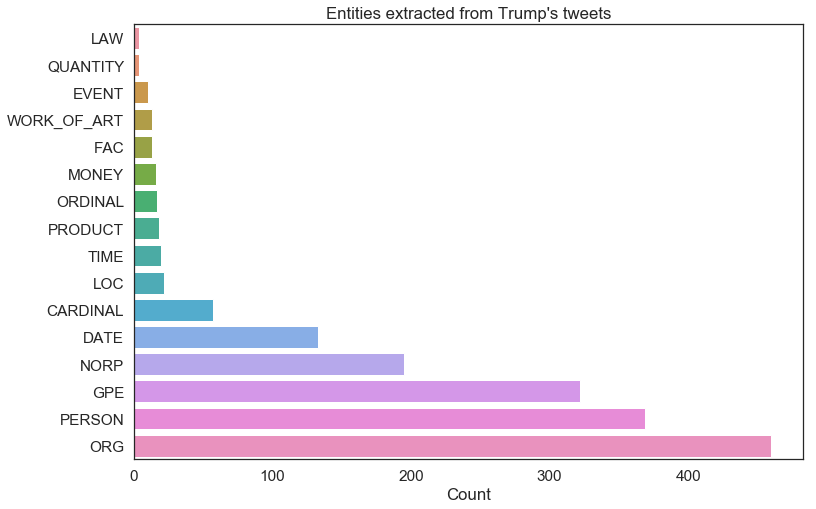

In [231]:
sns.barplot(data=df_entities_distribution, x='Count', y=df_entities_distribution.index)
plt.title('Entities extracted from Trump\'s tweets')

## Collection of replies/comments

Now as we collected all Trump's tweets for the desired period, we can loop through them and actually collect people's reactions by getting the replies to these tweets

In [ ]:
def collect_replies(tweets, file):
    """
    collect replies for all the collected tweets of the specified account,
    query gets 100 replies per page, 10 pages give 1000 replies in total,
    then compares with desired parameters,
    finally saves results to file.
    
    """
    for tweet in tweets:
        for page in tweepy.Cursor(
                api.search,
                # filter tweets by replies to @name and exclude retweets
                q='to:' + name + ' -filter:retweets',
                since_id=tweet['id'],
                count=100,
                # specifiy what type of search results you would prefer to receive.
                # default is "mixed"
                result_type='mixed',
                tweet_mode='extended').pages(10):
            for status in page:
                if hasattr(status, 'in_reply_to_status_id_str'):
                    logging.info('Found a reply to the tweet with id=',
                                 status.in_reply_to_status_id_str,
                                 'text=' + status.text)
                    replies.append(status._json)
                    logging.info('Reply added to the list. Continue...')

    json.dump(replies, file, indent=2)

In [ ]:
%%time
if os.path.isfile('replies.json') and not os.stat('replies.json').st_size == 0:
    logging.info('File replies.json already exists! Reading the file..')
    file = open('replies.json', 'r', encoding='utf8')
    replies = json.load(file)
    file.close()
else:
    logging.info('Creating replies.json, collecting tweets..')
    file = open('replies.json', 'w', encoding='utf8')
    replies = []
    collect_replies(tweets, file)
    file.close()

## Sentiment Analysis

Now we'll calculate the sentiment intensity for each of Trump's tweets using VADER which is especially tailored to work with social media texts

In [17]:
analyzer = SentimentIntensityAnalyzer()

sentiment_intensity = df['Text'].apply(lambda s: analyzer.polarity_scores(s))
sentiment_intensity = sentiment_intensity.apply(pd.Series)
df = pd.concat([df, sentiment_intensity], axis=1)
df.head()

,Text,len,id,Date,Likes,RTs,PERSON,GPE,CARDINAL,NORP,...,TIME,LAW,EVENT,WORK_OF_ART,FAC,QUANTITY,neg,neu,pos,compound
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21,101024,21110,2.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.063,0.608,0.329,0.9425
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21,222426,56149,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.386,0.614,0.000,-0.8932
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21,134130,31597,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21,125867,23394,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.702,0.298,0.9344
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21,143746,28589,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.076,0.743,0.180,0.7089


We mark the tweets as neutral/negative/positive based on the calculated sentiment intensity.

In [18]:
df.loc[(df['compound'] > -.05) &
       (df['compound'] < .05), 'Sentiment'] = 'neutral'
df.loc[df['compound'] <= -.05, 'Sentiment'] = 'negative'
df.loc[df['compound'] >= .05, 'Sentiment'] = 'positive'
df.head()

,Text,len,id,Date,Likes,RTs,PERSON,GPE,CARDINAL,NORP,...,LAW,EVENT,WORK_OF_ART,FAC,QUANTITY,neg,neu,pos,compound,Sentiment
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21,101024,21110,2.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.063,0.608,0.329,0.9425,positive
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21,222426,56149,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.386,0.614,0.000,-0.8932,negative
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21,134130,31597,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,neutral
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21,125867,23394,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000,0.702,0.298,0.9344,positive
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21,143746,28589,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.076,0.743,0.180,0.7089,positive


Now lets take a look at the count and distribution of positive/negative tweets based on these marks.

In [19]:
Counter(df['Sentiment'])

Counter({'positive': 299, 'negative': 212, 'neutral': 50})

Text(0.5, 1.0, "Trump's tweets")

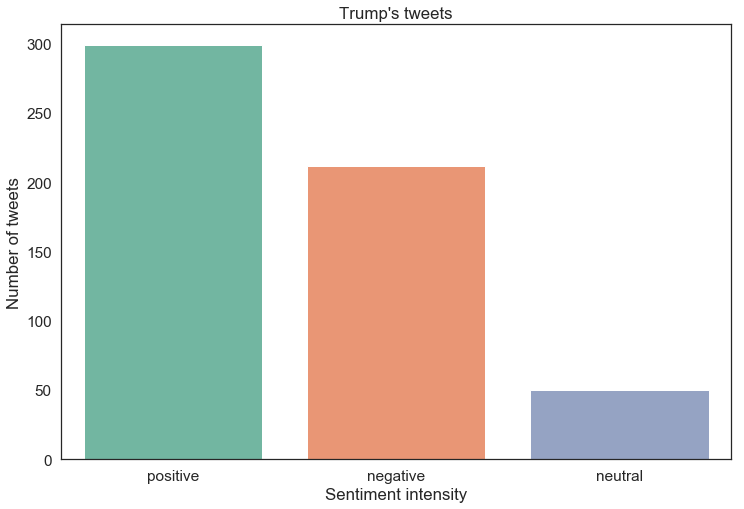

In [102]:
sns.countplot(df['Sentiment'])
plt.xlabel('Sentiment intensity')
plt.ylabel('Number of tweets')
plt.title('Trump\'s tweets')

## Correlation with approval ratings
Approval ratings data from https://projects.fivethirtyeight.com/trump-approval-ratings/

In [181]:
# disapproval rating
rating = [
    52.3, 52.4, 52.6, 52.7, 52.8, 52.8, 52.9, 53, 53.3, 53.2, 53.2, 53.3, 53.4,
    53.4, 53.4, 53.5, 53.4, 53.4, 53.5, 53.5, 53.6, 53.8, 53.8, 53.9, 53.9,
    53.9, 54.3, 54.4, 54.5, 54.9, 55.2, 55.2, 55.2, 55.2, 55.3, 55.0, 55.9,
    55.9, 56, 56, 56, 55.9, 55.8, 55.9, 55.9, 55.9, 55.9, 56, 55.7, 55.6, 55.4,
    55.3, 55.1, 55.1, 55.1, 55.1, 54.9, 54.1, 54.1, 54.0, 53.7, 53.7, 53.8,
    53.6, 53.6, 53.2, 53
]

# approval rating
# rating = [100 - x for x in rating]

dates = pd.date_range(start_date, end_date)

df_rating = pd.DataFrame(rating, index=dates, columns=['Rating'])
df_rating.head(10)

,Rating
2018-12-18,52.3
2018-12-19,52.4
2018-12-20,52.6
2018-12-21,52.7
2018-12-22,52.8
2018-12-23,52.8
2018-12-24,52.9
2018-12-25,53.0
2018-12-26,53.3
2018-12-27,53.2


In [183]:
scatter_data = pd.DataFrame({'Date': df['Date'], 'Rate': 45, 'Sentiment': df['Sentiment']})
scatter_data.loc[scatter_data['Sentiment'] == 'negative', 'Rate'] = 54
scatter_data.loc[scatter_data['Sentiment'] == 'positive', 'Rate'] = 54.5
scatter_data.loc[scatter_data['Sentiment'] == 'neutral', 'Rate'] = 53.5

Text(0.5, 1.0, "Donald Trump's daily disapproval rate")

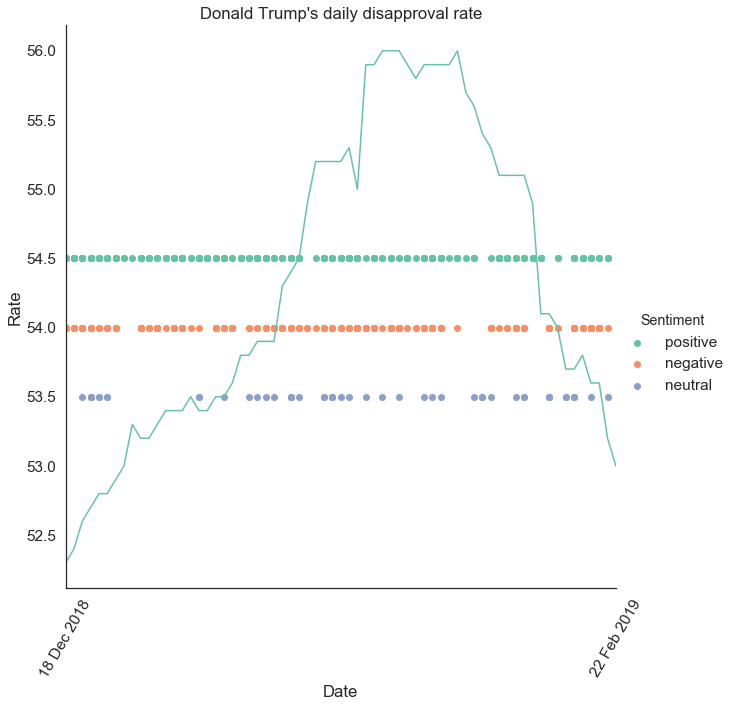

In [189]:
# sns.lineplot(df_rating.index, df_rating.Rating)
fig = sns.FacetGrid(data=scatter_data, hue='Sentiment', height=9)
fig.map(plt.scatter, 'Date', 'Rate').add_legend()
fig.axes[0, 0].plot(df_rating.index, df_rating.Rating)
plt.xticks(ticks=[df_rating.index[0], df_rating.index[-1]], labels=['18 Dec 2018', '22 Feb 2019'], rotation=60)
plt.xlim(df_rating.index[0], df_rating.index[-1])
plt.title('Donald Trump\'s daily disapproval rate')

In [134]:
df_plot = df.groupby(['Sentiment', 'Date']).size().reset_index().pivot(columns='Sentiment', index='Date', values=0)
# df_plot['negative'] = df_plot['negative'] + 27
# df_plot['neutral'] = df_plot['neutral'] + 27
# df_plot['positive'] = df_plot['positive'] + 27
df_plot.head()

Sentiment,negative,neutral,positive
Date,,,
2018-12-18,5.0,NaN,4.0
2018-12-19,4.0,NaN,8.0
2018-12-20,6.0,1.0,9.0
2018-12-21,5.0,4.0,11.0
2018-12-22,2.0,2.0,5.0


In [135]:
df_plot = df_plot[['positive', 'negative', 'neutral']]
df_plot.head()

Sentiment,positive,negative,neutral
Date,,,
2018-12-18,4.0,5.0,NaN
2018-12-19,8.0,4.0,NaN
2018-12-20,9.0,6.0,1.0
2018-12-21,11.0,5.0,4.0
2018-12-22,5.0,2.0,2.0


Text(0.5, 1.0, "Donald Trump's daily disapproval rate")

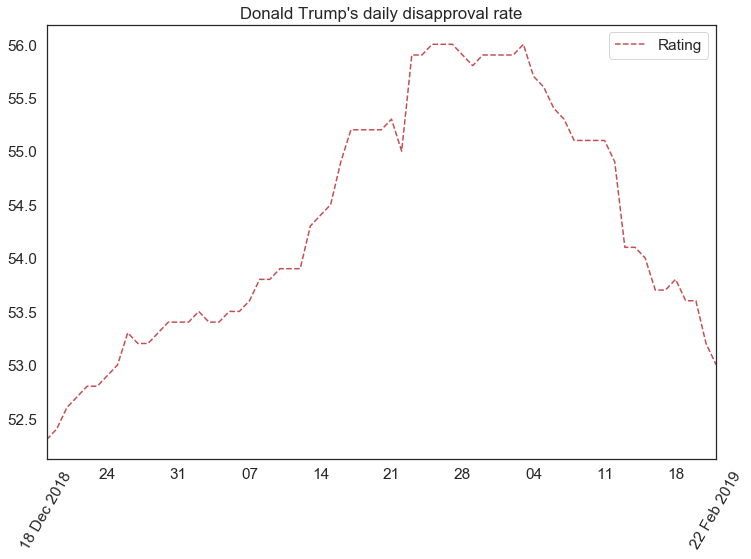

In [187]:
df_rating.plot(style='--r')
plt.xticks(ticks=[df_rating.index[0], df_rating.index[-1]], labels=['18 Dec 2018', '22 Feb 2019'], rotation=60)
plt.xlim(df_rating.index[0], df_rating.index[-1])
sns.set_style('white')
plt.title('Donald Trump\'s daily disapproval rate')

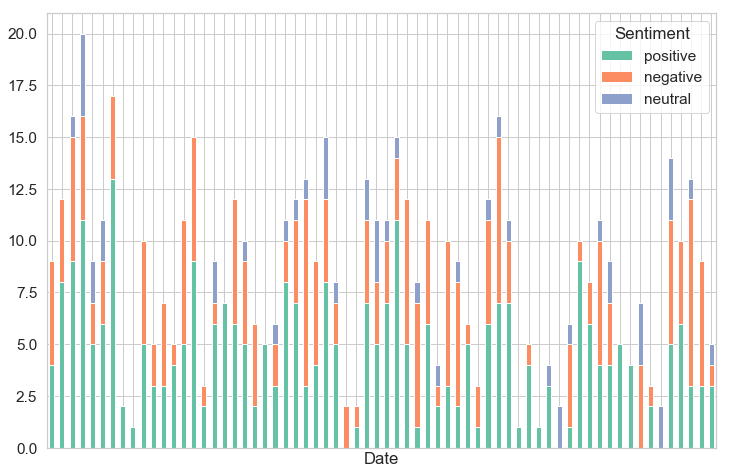

In [163]:
df_plot.plot(kind='bar', stacked=True)
sns.set(style='whitegrid', font_scale=1.4, palette='Set2', rc={"figure.figsize": [12, 8]})
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

Text(0.5, 1.0, "Trump's negative tweets daily")

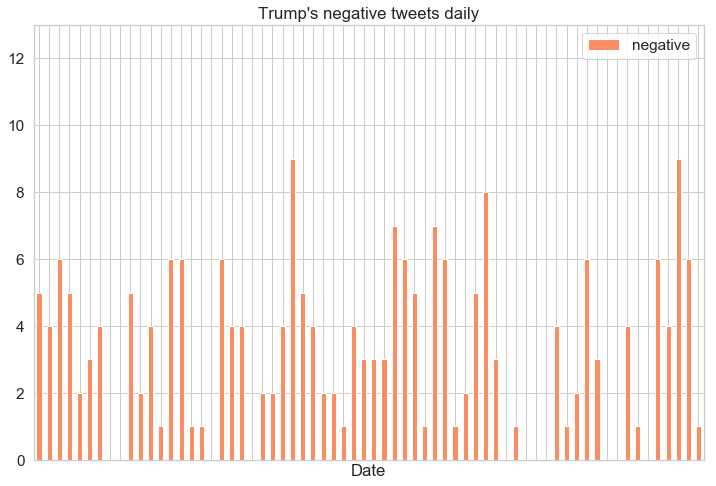

In [178]:
df_plot['negative'].plot(kind='bar', color=sns.color_palette()[1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylim(0, 13)
plt.title('Trump\'s negative tweets daily')

Text(0.5, 1.0, "Trump's positive tweets daily")

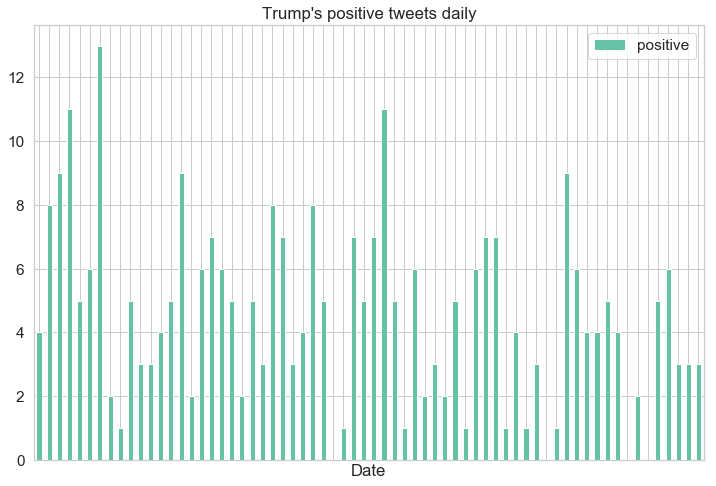

In [179]:
df_plot['positive'].plot(kind='bar', color=sns.color_palette()[0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.title('Trump\'s positive tweets daily')